In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
import os

In [90]:
def volcano(data, log2fc = 'log2FoldChange', pvalue = 'padj', symbol = 'symbol',
           baseMean = None, 
           pval_thresh = 0.05,
           log2fc_thresh = 0.75,
           to_label = 5, 
           color_dict = None, shape_dict = None,
           fontsize = 10,
           colors = ['dimgrey', 'lightgrey', 'black'],
           top_right_frame = False,
           figsize = (5,5), legend_pos = (1.4,1),
           
           point_sizes = (15,150),
           save = False, 
           shapes = None,
           shape_order = None):
    
    '''
    Make a volcano plot from a pandas dataframe of directly from a csv.
    
    data : pandas.DataFrame or path to csv
    log2fc : string
        column name of log2 Fold-Change values
    pvalue : string
        column name of the p values to be converted to -log10 P values
    symbol : string
        column name of gene IDs to use
    baseMean : string
        column name of base mean values for each gene. If this is passed, 
        the size of the points will vary.
    pval_thresh : numeric
        threshold pvalue for points to be significant. Also controls horizontal
        line.
    log2fc_thresh : numeric
        threshold for the absolute value of the log2 fold change to be considered
        significant. Also controls vertical lines
    to_label : int or list
        If an int is passed, that number of top down and up genes will be labeled.
        If a list of gene Ids is passed, only those will be labeled.
    color_dict : dictionary
        dictionary to color dots by. Up to 11 categories with default colors.
        Pass list of genes and the category to group them by. {category : ['gene1', gene2]}
        Default colors are: ['dimgrey', 'lightgrey', 'tab:blue', 'tab:orange',
        'tab:green', 'tab:red', 'tab:purple','tab:brown', 'tab:pink', 
        'tab:olive', 'tab:cyan']
    shape_dict : dictionary
        dictionary to shape dots by. Up to 6 categories. Pass list of genes as values
        and category as key. {category : ['gene1', gene2], category2 : ['gene3']}
        
    colors : list
        order and colors to use. Default ['dimgrey', 'lightgrey', 'black']
    top_right_frame : Boolean
        Show the top and right frame. True/False
    figsize : tuple
        Size of figure. (x, y)
    point_sizes : tuple
        lower and upper bounds of point sizes. If baseMean is not None.
        (lower, upper)
    save : boolean | string
        If true saves default file name. Pass string as path to output file. Will
        add a .svg/.png to string. Saves as both png and svg.
    shapes : list
        pass matplotlib marker ids to change default shapes/order
        Default shapes order is: ['o', '^', 's', 'X', '*', 'd']
    shape_order : list
        If you want to change the order of categories for your shapes. Pass
        a list of your categories.
    
    '''
    
    
    
    
    if isinstance(data, str):
        df = pd.read_csv(data)
    else: 
        df = data.copy(deep = True)
        
        
    #clean and imput 0s
    df = df.dropna()
    if df[pvalue].min() == 0:
        print('0s encountered for p value, imputing 1e-323')
        print('impute your own value if you want to avoid this')
        df[pvalue][df[pvalue] == 0] = 1e-323
        
        
    
    pval_thresh = -np.log10(pval_thresh) #convert p value threshold to nlog10
    df['nlog10'] = -np.log10(df[pvalue]) #make nlog10 column
    df['sorter'] = df['nlog10']*df[log2fc] #make a column to pick top genes
    
    
    #size the dots by basemean if a column id is passed
    if baseMean is not None:
        df['logBaseMean'] = np.log(df[baseMean])
        baseMean = 'logBaseMean'
    else:
        point_sizes = None
    
    
    #color dots by {label:[list of genes]}
    
    
    
    
    #make label list of top x genes up and down, or based on list input
    if isinstance(to_label, int):
        label_df = pd.concat(
        (df.sort_values('sorter')[-to_label:],
        df.sort_values('sorter')[0:to_label]))
        
    else:
        label_df = df[df[symbol].isin(to_label)]
        
        
        

    
    #color light grey if below thresh, color picked black
    def map_color_simple(a):
        log2FoldChange, zymbol, nlog10 = a
        if zymbol in label_df[symbol].tolist():
            return 'picked'
            
        if abs(log2FoldChange) < log2fc_thresh or nlog10 < pval_thresh:
            return 'not DE'
        return 'DE'
    
    if color_dict is None:
        df['color'] = df['color'] = df[[log2fc, symbol, 'nlog10']].apply(map_color_simple, axis = 1)
        hues = ['DE', 'not DE', 'picked'][:len(df.color.unique())] #order of colors
    
    #coloring if dictionary passed
    def map_color_complex(a):
        log2FoldChange, zymbol, nlog10 = a
        
        for k in list(color_dict):
            if zymbol in color_dict[k]:
                return k
        if abs(log2FoldChange) < log2fc_thresh or nlog10 < pval_thresh:
            return 'not DE'
        return 'DE'
    
    if color_dict is not None:
        df['color'] = df['color'] = df[[log2fc, symbol, 'nlog10']].apply(map_color_complex, axis = 1)
        user_added_cats = [x for x in df.color.unique() if x not in ['DE', 'not DE']]
        hues = ['DE', 'not DE'] + user_added_cats
        hues = hues[:len(df.color.unique())] #order of colors
        if colors == ['dimgrey', 'lightgrey', 'black']:
            colors = ['dimgrey', 'lightgrey', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                     'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
            
            
    #map shapes if dictionary exists
    def map_shape(zymbol):
        for k in list(shape_dict):
            if zymbol in shape_dict[k]:
                return k

        return 'other'
            
    if shape_dict is not None:
        df['shape'] =  df[symbol].map(map_shape)
        user_added_cats = [x for x in df['shape'].unique() if x  != 'other']
        shape_order = ['other'] + user_added_cats
        if shapes is None:
            shapes = ['o', '^', 's', 'X', '*', 'd']
        shapes = shapes[:len(df['shape'].unique())]
        shape_col = 'shape'
    else:
        shape_col = None
    
    
    

    #build palette
    colors = colors[:len(df.color.unique())]

    
    
    plt.figure(figsize = figsize)
    ax = sns.scatterplot(data = df, x = log2fc, y = 'nlog10',                 
                hue = 'color', hue_order = hues, palette = colors,
                        size = baseMean, sizes = point_sizes, 
                        style = shape_col, style_order = shape_order, markers = shapes)
    

    
    
    #make labels
    texts = []
    for i in range(len(label_df)):
        
        txt = plt.text(x = label_df.iloc[i][log2fc],
                              y = label_df.iloc[i].nlog10,
                              s = label_df.iloc[i][symbol],
                              fontsize = fontsize,
                              weight = 'bold')
        
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        texts.append(txt)
    adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k', zorder = 5))
    
    
    
    
    
    #plot vertical and horizontal lines
    ax.axhline(pval_thresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(log2fc_thresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(log2fc_thresh * -1, zorder = 0, c = 'k', lw = 2, ls = '--')
    
    
    
    #make things pretty
    for axis in ['bottom', 'left', 'top', 'right']:
        ax.spines[axis].set_linewidth(2)
        
    if not top_right_frame:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    ax.tick_params(width = 2)
    plt.xticks(size = 11, weight = 'bold')
    plt.yticks(size = 11, weight = 'bold')
    plt.xlabel("$log_{2}$ fold change", size = 15)
    plt.ylabel("-$log_{10}$ FDR", size = 15)
    
    plt.legend(loc = 1, bbox_to_anchor = legend_pos, frameon = False, prop = {'weight':'bold'})
    
    
    if save:
        files = os.listdir()
        for x in range(100):
            file_pref = "volcano_" + "%02d" % (x,)
            if len([x for x in files if x.startswith(file_pref)]) == 0:
                plt.savefig(file_pref + '.png', dpi = 300, bbox_inches = 'tight')
                plt.savefig(file_pref + '.svg', bbox_inches = 'tight')
                break
    elif isinstance(save, str):
        plt.savefig(save + '.png', dpi = 300, bbox_inches = 'tight')
        plt.savefig(save + '.svg', bbox_inches = 'tight')
                
    
    
    plt.show()

In [109]:
df = pd.read_csv('/home/jrlab2019/youtube/deseq/DE_results.csv')

In [110]:
df = df.rename(columns = {'baseMean': 'mean', 'log2FoldChange' : 'change'})

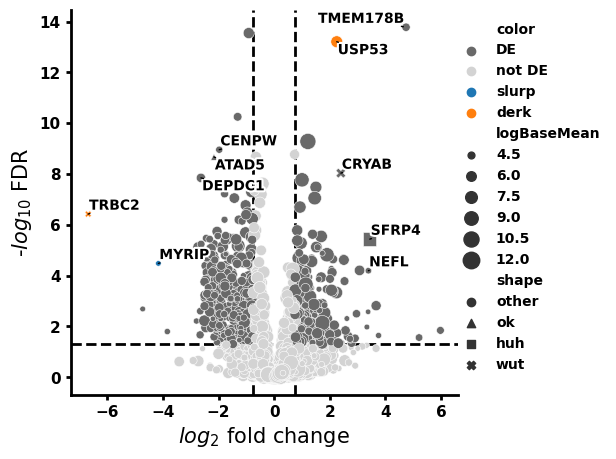

In [112]:
volcano(df, color_dict = {'derk' : ['USP53', 'TRBC2'], 'slurp': ['MYRIP']},
        shape_dict = {'wut' : ['CRYAB', 'TRBC2'], 'huh': ['SFRP4'], 'ok': ['ATAD5' ,'ACAP3']}, baseMean = 'mean',
       log2fc = 'change')

In [93]:
df

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
0,ENSG00000160072,320.481168,-0.492442,0.165330,-2.978533,0.002896,0.036899,ATAD3B
1,ENSG00000041988,103.354977,-0.282331,0.168099,-1.679553,0.093044,0.359646,THAP3
2,ENSG00000225630,922.811465,0.733032,0.375566,1.951807,0.050961,0.256948,MTND2P28
3,ENSG00000131584,735.890219,-0.053477,0.219621,-0.243496,0.807621,0.938042,ACAP3
4,ENSG00000169972,135.304763,-0.154869,0.187044,-0.827982,0.407681,0.727888,PUSL1
...,...,...,...,...,...,...,...,...
10926,ENSG00000198786,45775.084126,0.165326,0.206643,0.800055,0.423679,0.738798,ND5
10927,ENSG00000198695,10271.242782,0.184644,0.222985,0.828053,0.407640,0.727888,ND6
10928,ENSG00000198727,46929.471443,0.271033,0.258781,1.047347,0.294939,0.633176,CYTB
10929,ENSG00000210196,77.259551,0.454467,0.249443,1.821928,0.068466,0.304236,NaN


0s encountered for p value, imputing 1e-323
impute your own value if you want to avoid this


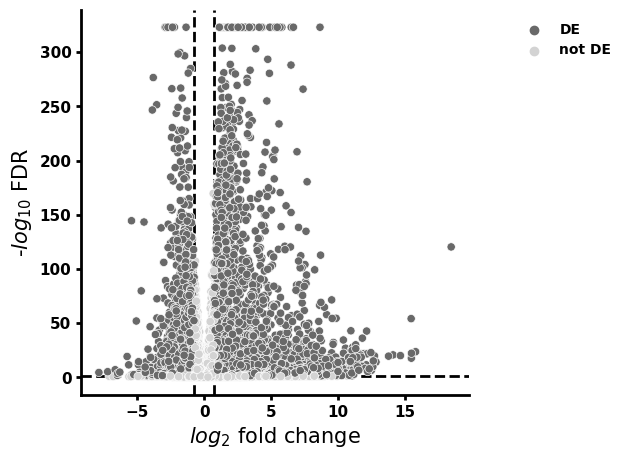

In [115]:
volcano(df, symbol='Unnamed: 0', to_label = [])

In [114]:
df = pd.read_csv('test_1.csv')

In [82]:
df[df.log2FoldChange == 0]

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
17,ENSMUSG00000103067,21.060103,0.0,1.726583,0.0,1.0,1.0
49,ENSMUSG00000025930,0.103649,0.0,5.267649,0.0,1.0,NaN
59,ENSMUSG00000089982,0.097630,0.0,5.267649,0.0,1.0,NaN
65,ENSMUSG00000101640,0.438053,0.0,5.267649,0.0,1.0,NaN
107,ENSMUSG00000053185,0.110643,0.0,5.267649,0.0,1.0,NaN
...,...,...,...,...,...,...,...
26027,ENSMUSG00000094514,0.349083,0.0,5.267649,0.0,1.0,NaN
26028,ENSMUSG00000094915,9.945419,0.0,1.884657,0.0,1.0,1.0
26032,ENSMUSG00000094874,0.301394,0.0,5.267649,0.0,1.0,NaN
26044,ENSMUSG00000096730,0.338913,0.0,5.267649,0.0,1.0,NaN


In [61]:
df.pvalue.min()

1e-323

In [348]:
volcano?

['DE', 'not DE', 'picked']
['dimgrey', 'lightgrey', 'black']


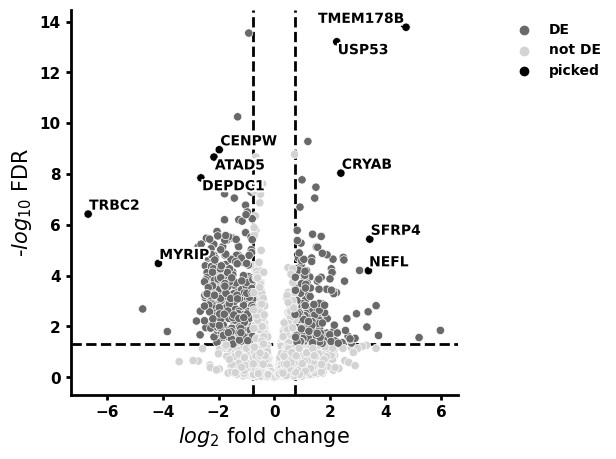

In [338]:
volcano('/home/jrlab2019/youtube/deseq/DE_results.csv')

In [279]:
df[df.color == 'derk']

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol,nlog10,color,sorter,logBaseMean
4,ENSG00000169972,135.304763,-0.154869,0.187044,-0.827982,0.407681,0.727888,PUSL1,0.137935,derk,-0.021362,4.907530
8,ENSG00000157933,2047.226762,-0.025201,0.204742,-0.123086,0.902039,0.970582,SKI,0.012968,derk,-0.000327,7.624241


In [342]:
df[df.color == 'DE']

AttributeError: 'DataFrame' object has no attribute 'color'

In [343]:
df

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
0,ENSG00000160072,320.481168,-0.492442,0.165330,-2.978533,0.002896,0.036899,ATAD3B
1,ENSG00000041988,103.354977,-0.282331,0.168099,-1.679553,0.093044,0.359646,THAP3
2,ENSG00000225630,922.811465,0.733032,0.375566,1.951807,0.050961,0.256948,MTND2P28
3,ENSG00000131584,735.890219,-0.053477,0.219621,-0.243496,0.807621,0.938042,ACAP3
4,ENSG00000169972,135.304763,-0.154869,0.187044,-0.827982,0.407681,0.727888,PUSL1
...,...,...,...,...,...,...,...,...
10926,ENSG00000198786,45775.084126,0.165326,0.206643,0.800055,0.423679,0.738798,ND5
10927,ENSG00000198695,10271.242782,0.184644,0.222985,0.828053,0.407640,0.727888,ND6
10928,ENSG00000198727,46929.471443,0.271033,0.258781,1.047347,0.294939,0.633176,CYTB
10929,ENSG00000210196,77.259551,0.454467,0.249443,1.821928,0.068466,0.304236,NaN
